In [1]:
import numpy as np

def syntheticY(n):
    """
    Synthetic rank-2 n x n matrix
    """
    U = np.vstack((np.arange(n)/n, (1-np.arange(n)/n)**2)).T
    W = np.vstack((np.arange(n)/n, (1-np.arange(n)/n)**2)).T
    return U @ W.T

def bernoulli(n,p):
    """
    Bernoulli sampling.
    Produces a set of index pairs I = {(i1,i2)} where
    i1,i2 = 0,...,n-1, and each pair is sampled with 
    probability p
    """
    I1, I2 = np.meshgrid(np.arange(n), np.arange(n))
    I1 = I1.flatten()
    I2 = I2.flatten()
    I = []
    for i1,i2 in zip(I1,I2):
        if (np.random.rand()<p):
            I.append([i1,i2])
    return np.array(I)

def Loss(U,W,Y,I):
    """
    Loss function (2), where 
    U, W are n x r factor matrices,
    Y is a n x n data matrix, 
    and I is a m x 2 matrix of index pairs
    """
    L = 0
    for i1,i2 in I:
        L = L + (U[i1] @ W[i2] - Y[i1,i2])**2
    return L / I.shape[0]

def initial(n,r):
    """
    Initial guess of the matrix factors
    """
    U0 = np.vstack((np.identity(r), np.zeros((n-r,r))))
    W0 = np.vstack((np.identity(r), np.zeros((n-r,r))))
    return U0, W0


def test_pointwise_gradient_1():
    """
    Unit tests for the pointwise gradient
    """
    Y = syntheticY(4)
    U,W = initial(4,2)
    vu = np.array([0,-1.125])
    vw = np.array([-1.125,0])
    assert np.array_equal(pointwise_gradient(U,W,Y,0,1), [vu, vw])
    
def test_pointwise_gradient_2():    
    Y = syntheticY(4)
    U,W = initial(4,2)
    vu = np.array([0,0])
    vw = np.array([-0.5,0])
    assert np.array_equal(pointwise_gradient(U,W,Y,0,2), [vu, vw])
    
def test_pointwise_gradient_3():        
    Y = syntheticY(4)
    U,W = initial(4,2)    
    vu = np.array([-0.5,0])
    vw = np.array([0,0])
    assert np.array_equal(pointwise_gradient(U,W,Y,2,0), [vu, vw])
    
    
def test_full_gradient_1():
    """
    Unit tests for the full gradient
    """
    Y = syntheticY(4)
    U,W = initial(4,2)
    Gu = np.array([[0,-1.125], [0,     0], [0,0], [0,0]])
    Gw = np.array([[0,     0], [-1.125,0], [0,0], [0,0]])
    assert np.array_equal(full_gradient(U,W,Y, np.array([[0,1]])), [Gu, Gw])    
    
def test_full_gradient_2():
    Y = syntheticY(4)
    U,W = initial(4,2)
    Gu = np.array([[0,    0], [-9/16,0], [0,   0], [0,0]]) 
    Gw = np.array([[0,-9/16], [0,    0], [-1/4,0], [0,0]])
    assert np.array_equal(full_gradient(U,W,Y, np.array([[1,0], [0,2]])), [Gu, Gw])    
    
def test_full_gradient_3():
    Y = syntheticY(4)
    U,W = initial(4,2)
    Gu = np.array([[0,-9/32], [-9/32,0], [-1/8,0], [0,0]]) 
    Gw = np.array([[0,-9/32], [-9/32,0], [0,   0], [0,0]])
    assert np.array_equal(full_gradient(U,W,Y, np.array([[1,0], [0,1], [2,0], [0,0]])), [Gu, Gw])    

# Question 1

In [2]:
def pointwise_gradient(U,W,Y,i1,i2):
    # compute formulas (5) and (6) in the assignment
    vu = 2*(U[i1,:] @ W[i2,:].T - Y[i1,i2])* W[i2,:]
    vw = 2*(U[i1,:] @ W[i2,:].T - Y[i1,i2])* U[i1,:]
    return vu,vw

# Question 2

In [3]:
def full_gradient(U,W,Y,I):
    # initialise Gu and Gw to same dimensions as U and W 
    Gu = np.zeros((U.shape[0],U.shape[1]))
    Gw = np.zeros((U.shape[0],U.shape[1]))
    # iterate over samples
    for i in range(I.shape[0]):
        i1 = I[i,0]
        i2 = I[i,1]
        # compute formulas (5) and (6) in the assignment  
        [vu,vw] = pointwise_gradient(U,W,Y,i1,i2)
        # increment ith row of Gu and Gw
        Gu[i1,:] = Gu[i1,:]+vu
        Gw[i2,:] = Gw[i2,:]+vw
    Gu=Gu/I.shape[0]
    Gw=Gw/I.shape[0]
    return Gu, Gw

# Question 3

In [19]:
from matplotlib import pyplot as plt
def gd(U0, W0, Y, I, Itest, t=1,eps=1e-6, K=100):
    #initialise starting values and arrays for iterations
    U = U0
    W = W0
    LossVals = np.zeros(0)
    kdagg = Loss(U,W,Y,Itest)
    for k in range(K):
        # save loss for log plot
        LossVals = np.append(LossVals,Loss(U,W,Y,Itest))
        # is loss sufficiently accurate?
        if (LossVals[k] < eps):
            print("converged in "+str(k)+" iterations")
            # if so exit iteration loop 
            break
        if (LossVals[k] > 100): 
            print('loss value at iteration '+str(k)+' is too big, stop algorithm t='+str(t))
            break
        # if not then calulate a sufficient update for U and W
        Gu,Gw = full_gradient(U,W,Y,I)
        U = U - t*Gu
        W = W - t*Gw
    print('the loss value at '+str(k)+' was '+str(LossVals[k])+' for t='+str(t))
    karray = np.arange(0,k+1)
    # plot k iterations on x-axis and loss values for each k on y-axis
    plt.plot(karray, LossVals, label = 't='+str(t)+'')
    # set the y-axis to log scale
    plt.yscale('log')
    # return U and W which minimise the loss function to sufficient accuracy 
    return U,W            

# Question 4

Ran 3 times and then computed the average for reproduceability (Note: using different testing and training sets for each run)

In [5]:
# function to create I, Itest
def createIs(Iext): 
    # shuffle an array of indicies of length Iext
    ind = np.arange(Iext.shape[0])
    np.random.shuffle(ind)
    # shuffle data pairs according to suffled indexes
    Irand = Iext[ind]
    # select first mu pairs to be the testing data set
    Itest = Irand[:mu,:]
    # select the remaining pairs to be the I data set
    I = Irand[Itest.shape[0]:Irand.shape[0]]
    return I, Itest

In [6]:
# initialising all variables required in description of question 

np.random.seed(0)
n=32
p=1
r = 2
mu = 20
Y = syntheticY(n)
Iext = bernoulli(n,p)
U0,W0=initial(n,r)
I, Itest = createIs(Iext)
K = 5000
eps = 1e-8
t = [1,2,4,8,16,32]


converged in 1120 iterations
the loss value at 1120 was 9.980461676684319e-09 for t=1
converged in 560 iterations
the loss value at 560 was 9.853979004444943e-09 for t=2
converged in 280 iterations
the loss value at 280 was 9.60203115704594e-09 for t=4
converged in 140 iterations
the loss value at 140 was 9.102122493833053e-09 for t=8
converged in 70 iterations
the loss value at 70 was 8.116977336146316e-09 for t=16
converged in 35 iterations
the loss value at 35 was 6.190982801618545e-09 for t=32


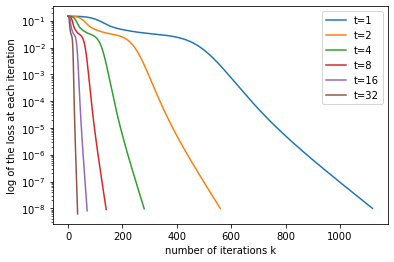

loss value at iteration 80 is too big, stop algorithm t=64
the loss value at 80 was 179.00657256646565 for t=64


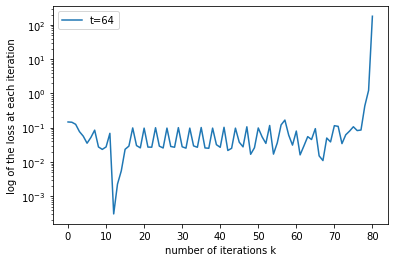

In [7]:
# 1st run 

# plotting log of loss against iterations k
frobnormsave = [] 
for i in t:
    U,W = gd(U0, W0, Y, I, Itest, i,eps, K)
    # calcuting the frobenius norm and saving it for each t
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave = np.append(frobnormsave,frobnorm)
# titles for plots
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Gradient Descent (GD) method for Matrix Completion (run 1)')
plt.legend()
plt.show()
# plotting t = 64 seperately due to different resolution
U,W = gd(U0, W0, Y, I, Itest, 64,eps, K)
frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
frobnormsave = np.append(frobnormsave,frobnorm)
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Gradient Descent (GD) method for Matrix Completion (run 1)')
plt.legend()
plt.show()

converged in 989 iterations
the loss value at 989 was 9.895551369911352e-09 for t=1
converged in 495 iterations
the loss value at 495 was 9.63206813686197e-09 for t=2
converged in 247 iterations
the loss value at 247 was 9.926279041326018e-09 for t=4
converged in 124 iterations
the loss value at 124 was 8.888184955487948e-09 for t=8
converged in 62 iterations
the loss value at 62 was 8.41468041533058e-09 for t=16
converged in 31 iterations
the loss value at 31 was 7.421879312266183e-09 for t=32


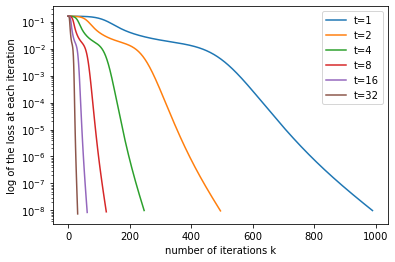

loss value at iteration 90 is too big, stop algorithm t=64
the loss value at 90 was 5951762.95178904 for t=64


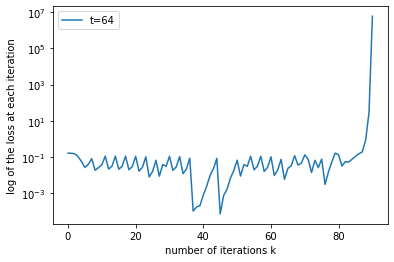

In [8]:
# second run 
I, Itest = createIs(Iext)
frobnormsave1 = [] 
for i in t:
    U,W = gd(U0, W0, Y, I, Itest, i,eps, K)
    # calcuting the frobenius norm and saving it for each t
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave1 = np.append(frobnormsave,frobnorm)
# titles for plots
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Gradient Descent (GD) method for Matrix Completion (run 2)')
plt.legend()
plt.show()
# plotting t = 64 seperately due to different resolution
U,W = gd(U0, W0, Y, I, Itest, 64,eps, K)
frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
frobnormsave1 = np.append(frobnormsave,frobnorm)
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Gradient Descent (GD) method for Matrix Completion (run 2)')
plt.legend()
plt.show()

converged in 1274 iterations
the loss value at 1274 was 9.855748448498271e-09 for t=1
converged in 637 iterations
the loss value at 637 was 9.882654551517296e-09 for t=2
converged in 319 iterations
the loss value at 319 was 9.602505517800192e-09 for t=4
converged in 160 iterations
the loss value at 160 was 9.051379183888803e-09 for t=8
converged in 80 iterations
the loss value at 80 was 9.232691054394484e-09 for t=16
converged in 40 iterations
the loss value at 40 was 9.557535793971314e-09 for t=32


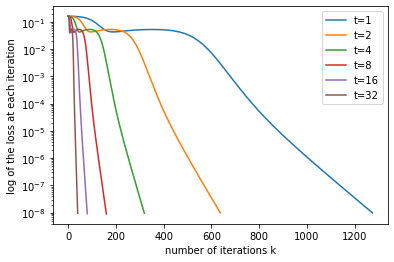

loss value at iteration 119 is too big, stop algorithm t=64
the loss value at 119 was 692005.8325373644 for t=64


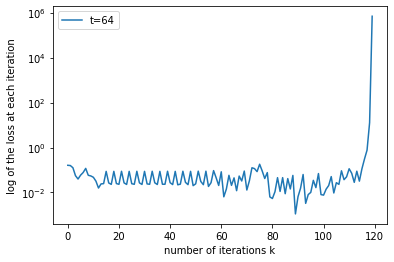

In [9]:
# third run 
I, Itest = createIs(Iext)
frobnormsave2 = [] 
for i in t:
    U,W = gd(U0, W0, Y, I, Itest, i,eps, K)
    # calcuting the frobenius norm and saving it for each t
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave2 = np.append(frobnormsave,frobnorm)
# titles for plots
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Gradient Descent (GD) method for Matrix Completion (run 3)')
plt.legend()
plt.show()
# plotting t = 64 seperately due to different resolution
U,W = gd(U0, W0, Y, I, Itest, 64,eps, K)
frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
frobnormsave2 = np.append(frobnormsave,frobnorm)
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Gradient Descent (GD) method for Matrix Completion (run 3)')
plt.legend()
plt.show()

Average Frobenius norm across all runs for written pdf. 

In [11]:
print('Average Frobenius norm for increasing t^i from 1-64')
for i in range(7):
    print((1/3)*(frobnormsave[i] + frobnormsave1[i] + frobnormsave2[i]))

0.0001896422060749921
0.00018777262845073606
0.00018398432435243339
0.0001762156444120005
0.0001599516027254508
0.0001249989603203094
48.63534797649846


# Question 5

In [20]:
def sag(U0, W0, Y, I,Itest, t=1, eps=1e-6, K=100):
    #initialise matrices 
    U = U0
    W = W0
    m = I.shape[0]
    Vu_tilde = np.zeros((m,U.shape[1]))
    Vw_tilde = np.zeros((m,U.shape[1]))
    Gu_tilde = np.zeros((U.shape[0],U.shape[1]))
    Gw_tilde = np.zeros((U.shape[0],U.shape[1]))
    LossValsS = np.zeros(0, dtype=float)
    for k in range(K):
        LossValsS = np.append(LossValsS,Loss(U,W,Y,Itest))
        if (LossValsS[k] < eps): 
            print("converged in "+str(k)+" iterations")
            # if so exit iteration loop 
            break
        if (LossValsS[k] > 100): 
            print('loss value at iteration '+str(k)+' is too big, stop algorithm for t='+str(t))
            break
        # sample i uniformly at random 
        i = np.arange(m)
        np.random.shuffle(i)
        i = i[0]
        # calculate the corresponding ith pair of I using random i
        i1 = I[i,0]
        i2 = I[i,1]
        # subtract old gradients 
        Gu_tilde[i1,:] = Gu_tilde[i1,:] - (1/m)*Vu_tilde[i,:]
        Gw_tilde[i2,:] = Gw_tilde[i2,:] - (1/m)*Vw_tilde[i,:]
        # compute new gradients 
        [Vu_tilde[i,:],Vw_tilde[i,:]] = pointwise_gradient(U,W,Y,i1,i2)
        # Add new gradients 
        Gu_tilde[i1,:] = Gu_tilde[i1,:] + (1/m)*Vu_tilde[i,:]
        Gw_tilde[i2,:] = Gw_tilde[i2,:] + (1/m)*Vw_tilde[i,:]
        # Update iterates 
        U = U-t*Gu_tilde
        W = W-t*Gw_tilde
    # create an array for the k iterations
    karray = np.arange(0,k+1)
    # plot k iterations on x-axis and loss values for each k on y-axis
    plt.plot(karray, LossValsS, label = 't='+str(t)+'')
    # set the y-axis to log scale
    plt.yscale('log')
    print('the loss value at '+str(k)+' was '+str(LossValsS[k])+' for t='+str(t))
    # return U and W which minimise the loss function to sufficient accuracy 
    return U,W

# Question 6

Ran 3 times for reproducability in same proceedure as question 4, with different maximum iterations

loss value at iteration 3012 is too big, stop algorithm for t=1
the loss value at 3012 was 104.47399315541789 for t=1
loss value at iteration 7427 is too big, stop algorithm for t=0.5
the loss value at 7427 was 102.24347451991909 for t=0.5


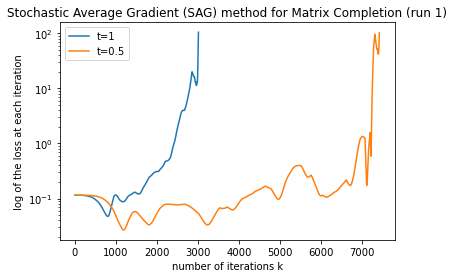

the loss value at 49999 was 1.3622219276664165e-07 for t=0.25
converged in 34397 iterations
the loss value at 34397 was 9.997063446770463e-09 for t=0.125
converged in 31923 iterations
the loss value at 31923 was 9.987824776294165e-09 for t=0.0625
converged in 33684 iterations
the loss value at 33684 was 9.994760637315859e-09 for t=0.03125
the loss value at 49999 was 2.427565972114296e-05 for t=0.015625


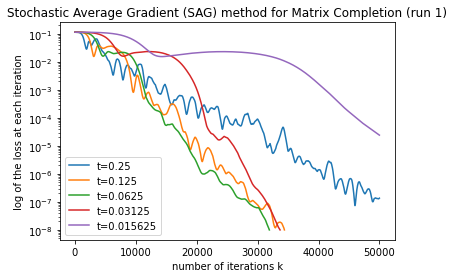

In [33]:
#the number of iterations is changed from question 4
K = 50000
eps = 1e-8
# plotting 1, 1/2 seperately due to different resolution

# RUN 1
# create a different permutation for I and Itest
I, Itest = createIs(Iext)
frobnormsave = [] 
t = [1,1/2]
for i in t: 
    U,W = sag(U0, W0, Y, I, Itest, i,eps, K)
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave = np.append(frobnormsave,frobnorm)
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Stochastic Average Gradient (SAG) method for Matrix Completion (run 1)')
plt.legend()
plt.show()
# plotting t values that have similar resolution that dont blow up!
t = [1/4,1/8,1/16,1/32,1/64]

for i in t:
    U,W = sag(U0, W0, Y, I, Itest, i,eps, K)
    # calcuting the frobenius norm and saving it for each t
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave = np.append(frobnormsave,frobnorm)
# titles for plots
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Stochastic Average Gradient (SAG) method for Matrix Completion (run 1)')
plt.legend()
plt.show()

loss value at iteration 2918 is too big, stop algorithm for t=1
the loss value at 2918 was 104.1794905692511 for t=1
loss value at iteration 10027 is too big, stop algorithm for t=0.5
the loss value at 10027 was 124.38840082334471 for t=0.5


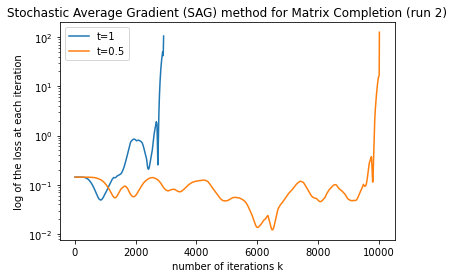

the loss value at 49999 was 7.064275549208246e-07 for t=0.25
converged in 34510 iterations
the loss value at 34510 was 9.99179256299337e-09 for t=0.125
converged in 33303 iterations
the loss value at 33303 was 9.99564911667753e-09 for t=0.0625
converged in 40340 iterations
the loss value at 40340 was 9.99986032126327e-09 for t=0.03125
the loss value at 49999 was 0.0002754742488160346 for t=0.015625


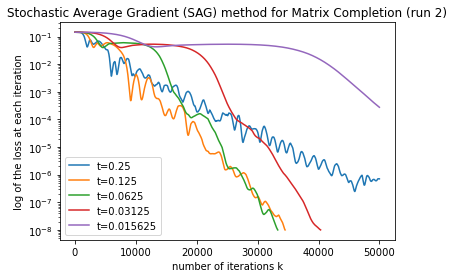

In [34]:
# RUN 2
# create a different permutation for I and Itest
I, Itest = createIs(Iext)
frobnormsave1 = [] 
t = [1,1/2]
for i in t: 
    U,W = sag(U0, W0, Y, I, Itest, i,eps, K)
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave1 = np.append(frobnormsave,frobnorm)
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Stochastic Average Gradient (SAG) method for Matrix Completion (run 2)')
plt.legend()
plt.show()
# plotting t values that have similar resolution that dont blow up!
t = [1/4,1/8,1/16,1/32,1/64]
for i in t:
    U,W = sag(U0, W0, Y, I, Itest, i,eps, K)
    # calcuting the frobenius norm and saving it for each t
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave1 = np.append(frobnormsave,frobnorm)
# titles for plots
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Stochastic Average Gradient (SAG) method for Matrix Completion (run 2)')
plt.legend()
plt.show()

loss value at iteration 3513 is too big, stop algorithm for t=1
the loss value at 3513 was 104.94929343487327 for t=1
loss value at iteration 9815 is too big, stop algorithm for t=0.5
the loss value at 9815 was 110.90323747086575 for t=0.5


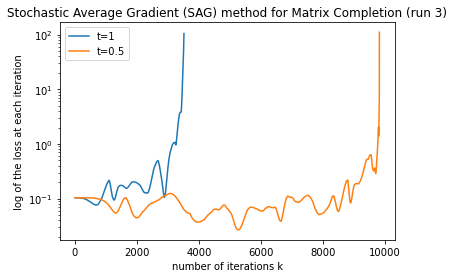

the loss value at 49999 was 5.209258271153829e-08 for t=0.25
converged in 34545 iterations
the loss value at 34545 was 9.99776905129805e-09 for t=0.125
converged in 37125 iterations
the loss value at 37125 was 9.998713746375011e-09 for t=0.0625
converged in 43394 iterations
the loss value at 43394 was 9.990650752428566e-09 for t=0.03125
the loss value at 49999 was 0.032885275624277566 for t=0.015625


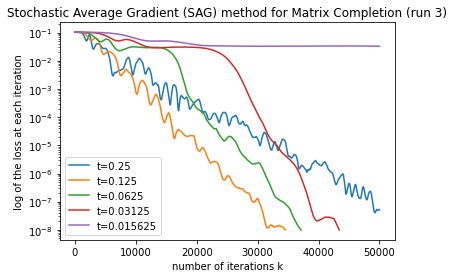

In [36]:
# RUN 3
# create a different permutation for I and Itest
I, Itest = createIs(Iext)
frobnormsave2 = [] 
t = [1,1/2]
for i in t: 
    U,W = sag(U0, W0, Y, I, Itest, i,eps, K)
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave2 = np.append(frobnormsave,frobnorm)
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Stochastic Average Gradient (SAG) method for Matrix Completion (run 3)')
plt.legend()
plt.show()
# plotting t values that have similar resolution that dont blow up!
t = [1/4,1/8,1/16,1/32,1/64]
for i in t:
    U,W = sag(U0, W0, Y, I, Itest, i,eps, K)
    # calcuting the frobenius norm and saving it for each t
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave2 = np.append(frobnormsave,frobnorm)
# titles for plots
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Stochastic Average Gradient (SAG) method for Matrix Completion (run 3)')
plt.legend()
plt.show()

In [38]:
print('Average Frobenius norm for increasing i with 1/t^i from 1 to 1/64')
for i in range(7):
    print((1/3)*(frobnormsave[i] + frobnormsave1[i] + frobnormsave2[i]))

Average Frobenius norm for increasing i with 1/t^i from 1 to 1/64
30.030491415878288
4251.20587331164
0.0008124153580489851
0.00033638404888243603
0.00024946534498733946
0.00021932800859761044
0.00951639951635317


# Question 7

This will be done in steps: 
* Loading in the data 
* Initialising variables specified in question 
* Running GD and SGD x2 and finding $L_{Low}$ for respective runs
* Finding the $t$ value which gives the fastest convergence (x2)

In [17]:
# initialising all variables required in description of question

#loading the data and storing it as a matrix called Y
np.random.seed(1)

data=np.load('CW.npz')
Y=data['Y']
n=Y.shape[0]
mu = 20
p=1/3
r=4
Iext = bernoulli(n,p)
U0,W0=initial(n,r)
I, Itest = createIs(Iext)
K = 5000
eps = 1.0e-8
t = [1,2,4,8,16,32,64]



Running GD two times to check for reducability in results (Note: using different testing and training sets)

the loss value at 4999 was 0.007716006328542054 for t=1
the loss value at 4999 was 0.0034954883750474295 for t=2
the loss value at 4999 was 0.002121139037511279 for t=4
the loss value at 4999 was 0.0018294204513026788 for t=8
the loss value at 4999 was 0.0017730281702907648 for t=16
the loss value at 4999 was 0.07910263113667576 for t=32


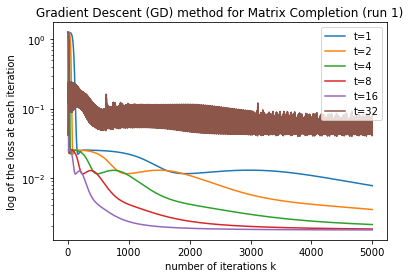

loss value at iteration 6 is too big, stop algorithm t=64
the loss value at 6 was 146.33155631767244 for t=64


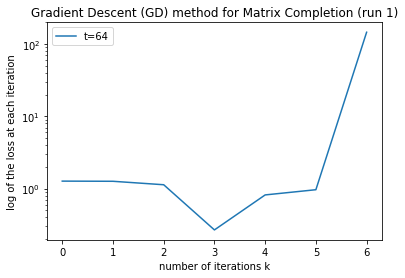

the loss value at 4999 was 0.006460579511994191 for t=1
the loss value at 4999 was 0.004180110885865918 for t=2
the loss value at 4999 was 0.005159881789417569 for t=4
the loss value at 4999 was 0.004224643562368216 for t=8
the loss value at 4999 was 0.00925924386519562 for t=16
the loss value at 4999 was 0.23430910573206884 for t=32


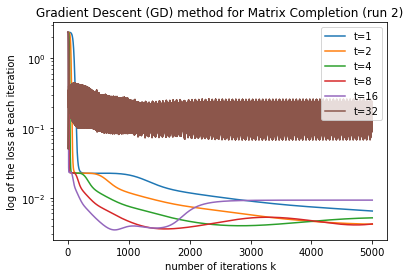

loss value at iteration 7 is too big, stop algorithm t=64
the loss value at 7 was 1210047796.0507398 for t=64


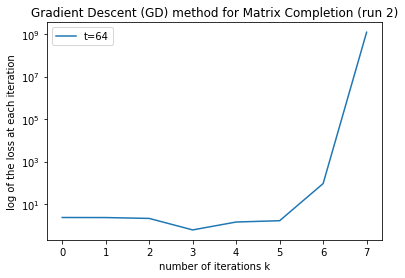

Average Frobenius norm for increasing t^i from 1-64
0.05472871773064081
0.0436990171453183
0.044913686277408896
0.04557739892247233
0.04575025533508791
0.9583462110744541
38.51327187418235


In [51]:
## NOTE: THIS TAKES 25 MINS TO RUN!

# Run 1 of GD
frobnormsave = [] 
t = [1,2,4,8,16,32]
for i in t:
    U,W = gd(U0, W0, Y, I, Itest, i,eps, K)
    # calcuting the frobenius norm and saving it for each t
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave = np.append(frobnormsave,frobnorm)
# titles for plots
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Gradient Descent (GD) method for Matrix Completion (run 1)')
plt.legend()
plt.show()
# plotting 64 seperately due to different resolution
U,W = gd(U0, W0, Y, I, Itest, 64,eps, K)
frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
frobnormsave = np.append(frobnormsave,frobnorm)
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Gradient Descent (GD) method for Matrix Completion (run 1)')
plt.legend()
plt.show()

# Run 2 of GD
# change I and Itest data sets
I1, Itest1 = createIs(Iext)
frobnormsave1 = [] 
t = [1,2,4,8,16,32]
for i in t:
    U,W = gd(U0, W0, Y, I1, Itest1, i,eps, K)
    # calcuting the frobenius norm and saving it for each t
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave1 = np.append(frobnormsave,frobnorm)
# titles for plots
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Gradient Descent (GD) method for Matrix Completion (run 2)')
plt.legend()
plt.show()
# plotting 64 seperately due to different resolution
U,W = gd(U0, W0, Y, I1, Itest1, 64,eps, K)
frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
frobnormsave1 = np.append(frobnormsave,frobnorm)
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Gradient Descent (GD) method for Matrix Completion (run 2)')
plt.legend()
plt.show()

# calculating the average Frobenius norm values for increasing t
print('Average Frobenius norm for increasing t^i from 1-64')
for i in range(7):
    print((1/2)*(frobnormsave[i] + frobnormsave1[i]))

Running SAG two times to check for reducability in results (Note: using different testing and training sets)

loss value at iteration 1815 is too big, stop algorithm for t=1
the loss value at 1815 was 103.6848892458178 for t=1
loss value at iteration 3060 is too big, stop algorithm for t=0.5
the loss value at 3060 was 108.99659077211541 for t=0.5
loss value at iteration 6324 is too big, stop algorithm for t=0.25
the loss value at 6324 was 101.11156288481202 for t=0.25
loss value at iteration 21087 is too big, stop algorithm for t=0.125
the loss value at 21087 was 104.28025909932894 for t=0.125


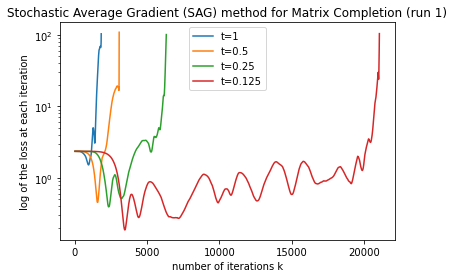

the loss value at 49999 was 0.010504701650727657 for t=0.0625
the loss value at 49999 was 0.02487297843880441 for t=0.03125
the loss value at 49999 was 0.02400160767220706 for t=0.015625


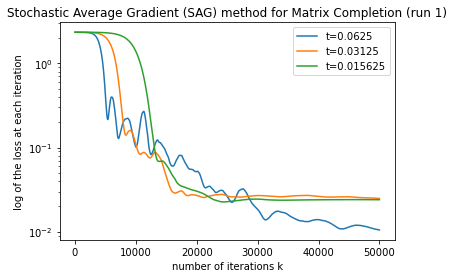

loss value at iteration 1850 is too big, stop algorithm for t=1
the loss value at 1850 was 151.19790475715965 for t=1
loss value at iteration 2990 is too big, stop algorithm for t=0.5
the loss value at 2990 was 100.88114550279529 for t=0.5
loss value at iteration 6608 is too big, stop algorithm for t=0.25
the loss value at 6608 was 103.4857859985356 for t=0.25
loss value at iteration 20409 is too big, stop algorithm for t=0.125
the loss value at 20409 was 101.58999986196989 for t=0.125


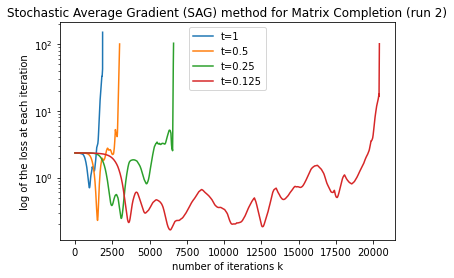

the loss value at 49999 was 0.012054233821322136 for t=0.0625
the loss value at 49999 was 0.015759654120829227 for t=0.03125
the loss value at 49999 was 0.022970488966494073 for t=0.015625


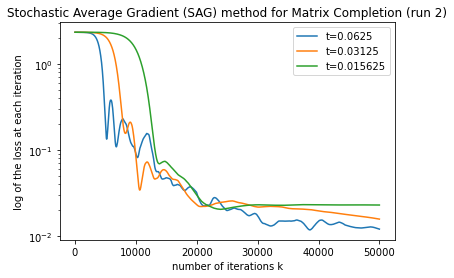

Average Frobenius norm for increasing t^i from 1-1/64
13.313392580177505
22.991319575510236
28.57295953683959
390057.6869718698
0.07702741990466157
0.1005363547446034
0.11762976857525714


In [53]:
# change number of iterations for this test
K = 50000
eps = 1e-8
# plotting 1, 1/2,1/4,1/8 seperately due to different resolution

# RUN 1 of SAG
frobnormsave = [] 
t = [1,1/2,1/4,1/8]
for i in t: 
    U,W = sag(U0, W0, Y, I, Itest, i,eps, K)
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave = np.append(frobnormsave,frobnorm)
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Stochastic Average Gradient (SAG) method for Matrix Completion (run 1)')
plt.legend()
plt.show()
# plotting t values that have similar resolution that dont blow up!
t = [1/16,1/32,1/64]
for i in t:
    U,W = sag(U0, W0, Y, I, Itest, i,eps, K)
    # calcuting the frobenius norm and saving it for each t
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave = np.append(frobnormsave,frobnorm)
# titles for plots
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Stochastic Average Gradient (SAG) method for Matrix Completion (run 1)')
plt.legend()
plt.show()

# RUN 2 of SAG 

frobnormsave1 = [] 
t = [1,1/2,1/4,1/8]
for i in t: 
    U,W = sag(U0, W0, Y, I1, Itest1, i,eps, K)
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave1 = np.append(frobnormsave,frobnorm)
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Stochastic Average Gradient (SAG) method for Matrix Completion (run 2)')
plt.legend()
plt.show()
# plotting t values that have similar resolution that dont blow up!
t = [1/16,1/32,1/64]
for i in t:
    U,W = sag(U0, W0, Y, I1, Itest1, i,eps, K)
    # calcuting the frobenius norm and saving it for each t
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave1 = np.append(frobnormsave,frobnorm)
# titles for plots
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Stochastic Average Gradient (SAG) method for Matrix Completion (run 2)')
plt.legend()
plt.show()

# compute the average frobenius norm

print('Average Frobenius norm for increasing t^i from 1-1/64')
for i in range(7):
    print((1/2)*(frobnormsave[i] + frobnormsave1[i]))

For SG
* Run 1: $L_{low} = 0.0017730281702907648$
* Run 2: $L_{low} = 0.004180110885865918$

For SAG
* Run 1: $L_{low} = 0.010504701650727657$
* Run 2: $L_{low} = 0.012054233821322136$

Proceed to re-run tests with $\epsilon = 2*L_{low}$ and changed maximum iterations where nessaccery

(NOTE: Originally set $K=10000$, but tests took 1hr to run... Setting $K=3000$ is sufficient to obtain the quickest converging $t$)

the loss value at 2999 was 0.012925027582220552 for t=1
the loss value at 2999 was 0.005718114045265154 for t=2
converged in 2447 iterations
the loss value at 2447 was 0.0035457974200612517 for t=4
converged in 1213 iterations
the loss value at 1213 was 0.003545596602725843 for t=8
converged in 595 iterations
the loss value at 595 was 0.0035413436630722197 for t=16
the loss value at 2999 was 0.08187399806301829 for t=32


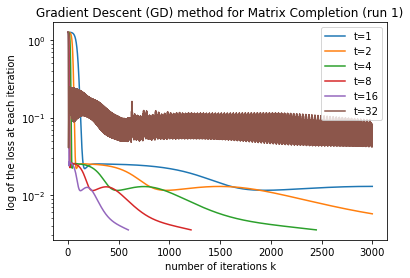

loss value at iteration 6 is too big, stop algorithm t=64
the loss value at 6 was 146.33155631767244 for t=64


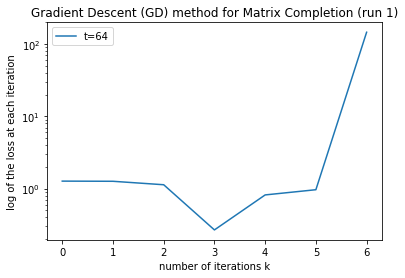

the loss value at 2999 was 0.008956469311753552 for t=1
converged in 1671 iterations
the loss value at 1671 was 0.008360026188405274 for t=2
converged in 853 iterations
the loss value at 853 was 0.008358337960403642 for t=4
converged in 443 iterations
the loss value at 443 was 0.008355574872528677 for t=8
converged in 236 iterations
the loss value at 236 was 0.008356740866570738 for t=16
the loss value at 2999 was 0.20436304556563586 for t=32


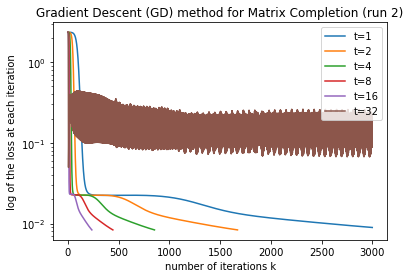

loss value at iteration 7 is too big, stop algorithm t=64
the loss value at 7 was 1210047796.0507398 for t=64


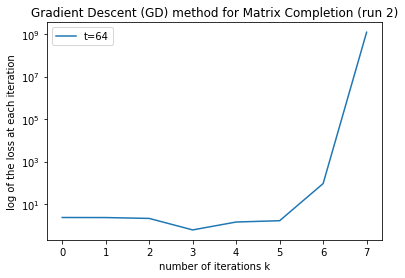

Average Frobenius norm for increasing t^i from 1-64
0.06879717947313183
0.05014335585153289
0.043728538461155486
0.04374127219032466
0.0437817335923266
0.9325071930242476
38.51327187418235


In [94]:
## NOTE: THIS TAKES A LONG TIME TO RUN!
K=3000
# Run 1 of SG1 for eps = 2*0.0017730281702907648
eps = 2*0.0017730281702907648
frobnormsave = [] 
t = [1,2,4,8,16,32]
for i in t:
    U,W = gd(U0, W0, Y, I, Itest, i,eps, K)
    # calcuting the frobenius norm and saving it for each t
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave = np.append(frobnormsave,frobnorm)
# titles for plots
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Gradient Descent (GD) method for Matrix Completion (run 1)')
plt.legend()
plt.show()
# plotting 64 seperately due to different resolution
U,W = gd(U0, W0, Y, I, Itest, 64,eps, K)
frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
frobnormsave = np.append(frobnormsave,frobnorm)
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Gradient Descent (GD) method for Matrix Completion (run 1)')
plt.legend()
plt.show()

# Run 2 of GD for eps = 2*0.004180110885865918
eps = 2*0.004180110885865918
# change I and Itest data sets
frobnormsave1 = [] 
t = [1,2,4,8,16,32]
for i in t:
    U,W = gd(U0, W0, Y, I1, Itest1, i,eps, K)
    # calcuting the frobenius norm and saving it for each t
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave1 = np.append(frobnormsave,frobnorm)
# titles for plots
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Gradient Descent (GD) method for Matrix Completion (run 2)')
plt.legend()
plt.show()
# plotting 64 seperately due to different resolution
U,W = gd(U0, W0, Y, I1, Itest1, 64,eps, K)
frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
frobnormsave1 = np.append(frobnormsave,frobnorm)
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Gradient Descent (GD) method for Matrix Completion (run 2)')
plt.legend()
plt.show()

# calculating the average Frobenius norm values for increasing t
print('Average Frobenius norm for increasing t^i from 1-64')
for i in range(7):
    print((1/2)*(frobnormsave[i] + frobnormsave1[i]))

loss value at iteration 1952 is too big, stop algorithm for t=1
the loss value at 1952 was 100.38842439345498 for t=1
loss value at iteration 3114 is too big, stop algorithm for t=0.5
the loss value at 3114 was 100.14768436538677 for t=0.5
loss value at iteration 6655 is too big, stop algorithm for t=0.25
the loss value at 6655 was 101.62968008558552 for t=0.25
loss value at iteration 15132 is too big, stop algorithm for t=0.125
the loss value at 15132 was 100.88923423819332 for t=0.125


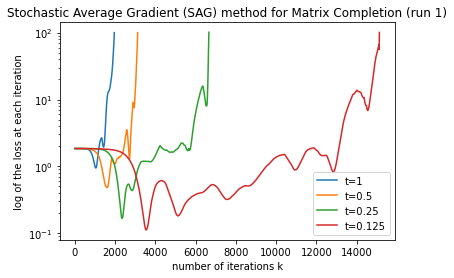

converged in 41158 iterations
the loss value at 41158 was 0.021006828863447274 for t=0.0625
the loss value at 49999 was 0.03630205622143094 for t=0.03125
the loss value at 49999 was 0.0464452649352613 for t=0.015625


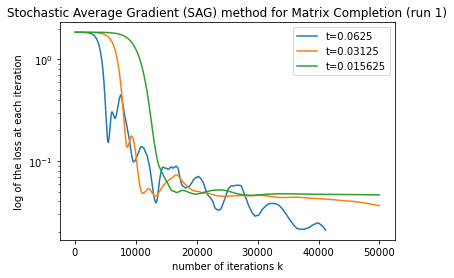

loss value at iteration 1937 is too big, stop algorithm for t=1
the loss value at 1937 was 635.7406648075366 for t=1
loss value at iteration 3186 is too big, stop algorithm for t=0.5
the loss value at 3186 was 100.10698604917111 for t=0.5
loss value at iteration 7380 is too big, stop algorithm for t=0.25
the loss value at 7380 was 104.82293794831662 for t=0.25
loss value at iteration 21348 is too big, stop algorithm for t=0.125
the loss value at 21348 was 101.21249541727884 for t=0.125


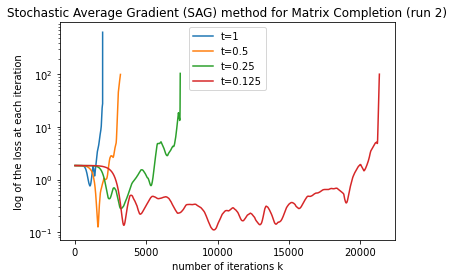

converged in 30472 iterations
the loss value at 30472 was 0.02410557921888988 for t=0.0625
the loss value at 49999 was 0.031830986484798075 for t=0.03125
the loss value at 49999 was 0.0482517152961788 for t=0.015625


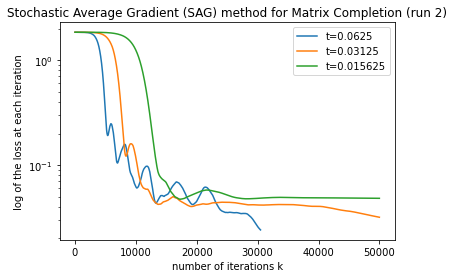

Average Frobenius norm for increasing t^i from 1-1/64
54.25976876148113
14.90388584386282
109083.36090683022
11.371580242420599
0.08473476648252666
0.11226283988133913
0.11784878672134419


In [71]:

K = 50000
# plotting 1, 1/2,1/4,1/8 seperately due to different resolution

# RUN 1 of SAG with eps = 2*0.010504701650727657
eps = 2*0.010504701650727657
frobnormsave = [] 
t = [1,1/2,1/4,1/8]
for i in t: 
    U,W = sag(U0, W0, Y, I, Itest, i,eps, K)
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave = np.append(frobnormsave,frobnorm)
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Stochastic Average Gradient (SAG) method for Matrix Completion (run 1)')
plt.legend()
plt.show()
# plotting t values that have similar resolution that dont blow up!
t = [1/16,1/32,1/64]
for i in t:
    U,W = sag(U0, W0, Y, I, Itest, i,eps, K)
    # calcuting the frobenius norm and saving it for each t
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave = np.append(frobnormsave,frobnorm)
# titles for plots
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Stochastic Average Gradient (SAG) method for Matrix Completion (run 1)')
plt.legend()
plt.show()

# RUN 2 of SAG with eps = 2*0.012054233821322136
eps = 2*0.012054233821322136
frobnormsave1 = [] 
t = [1,1/2,1/4,1/8]
for i in t: 
    U,W = sag(U0, W0, Y, I1, Itest1, i,eps, K)
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave1 = np.append(frobnormsave,frobnorm)
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Stochastic Average Gradient (SAG) method for Matrix Completion (run 2)')
plt.legend()
plt.show()
# plotting t values that have similar resolution that dont blow up!
t = [1/16,1/32,1/64]
for i in t:
    U,W = sag(U0, W0, Y, I1, Itest1, i,eps, K)
    # calcuting the frobenius norm and saving it for each t
    frobnorm = np.linalg.norm(U @ W.T - Y)/np.linalg.norm(Y)
    frobnormsave1 = np.append(frobnormsave,frobnorm)
# titles for plots
plt.ylabel('log of the loss at each iteration')
plt.xlabel('number of iterations k')
plt.title('Stochastic Average Gradient (SAG) method for Matrix Completion (run 2)')
plt.legend()
plt.show()

# compute the average frobenius norm

print('Average Frobenius norm for increasing t^i from 1-1/64')
for i in range(7):
    print((1/2)*(frobnormsave[i] + frobnormsave1[i]))

computing images Y and most accurate $UW^T$ computed. Choose $eps=2*0.0017730281702907648$ (since this was the minimum loss found overall described above) and $t=16$ (quickest average convergence, smallest number of iterations till convergence...) for GD algorithm (accuracy) 

This is the image of Y (IMAGE 1)


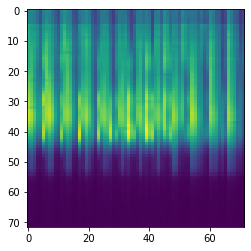

converged in 595 iterations
the loss value at 595 was 0.0035413436630722197 for t=16
This is the image of UW.T computed via Matrix Completion using GD (IMAGE 2)


/tmp/ipykernel_1030203/629753498.py:10: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.imshow(UG @ WG.T)


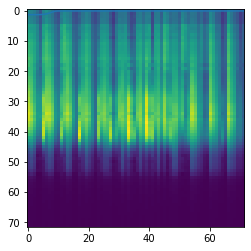

In [96]:
K=10000
print('This is the image of Y (IMAGE 1)')
# display matrix Y as image
plt.imshow(Y)
plt.show()
# compute GS with computed eps and sufficient K iterations max 
UG,WG = gd(U0, W0, Y, I, Itest, 16,2*0.0017730281702907648, K)
print('This is the image of UW.T computed via Matrix Completion using GD (IMAGE 2)')
# display UW.T as image
plt.imshow(UG @ WG.T)
plt.yscale('linear')
plt.show()